In [1]:
#IMPORTS put all here
import random
import matplotlib.pyplot as plt

#tf imports for reading file
import numpy as np
import os
import PIL

import PIL.Image
import tensorflow as tf
import tensorflow_datasets as tfds

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout, BatchNormalization


#extras
print(tf.__version__)
import pathlib
import shutil

c:\Users\Bhavini\AppData\Local\Programs\Python\Python310\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


2.9.1


In [2]:
#path to image dataset
spec_path = os.path.join(os.curdir,'spectrograms6sec')

genre_list=os.listdir(spec_path)
genre_list


['bhojpuri_pop',
 'carnatic',
 'classic_bollywood',
 'desi_pop',
 'ghazal',
 'hindustani_classical',
 'indian_indie',
 'punjabi_hip_hop',
 'sufi',
 'tamil_pop']

In [3]:
#resets the experiment
%rm -rf content/spectrograms6secnew

UsageError: Line magic function `%rm` not found.


In [4]:
# os.mkdir(os.path.join(os.curdir,'spectrograms6secnew'))
dest_path='spectrograms6secnew'

#for genre in genre_list:
#  os.mkdir(f'spectrograms6secnew/{genre}')

In [5]:


#no of samples per class
n=3000
cnt=0

random.seed(123)

for genre in genre_list:
  genre_path=os.path.join(spec_path,genre)
  dest_genre_path=os.path.join(dest_path,genre)

  #shuffling and selecting 3000 samples
  genre_songs=os.listdir(genre_path)
  random.shuffle(genre_songs)
  selected_spec=genre_songs[:n]
  
  for song in selected_spec:
      source=os.path.join(genre_path,song)
      dest=os.path.join(dest_genre_path,song)
      d= shutil.copyfile(source, dest)




In [6]:
data_dir=pathlib.Path(dest_path)
data_dir

WindowsPath('spectrograms6secnew')

In [7]:
#adding dataset
batch_size=64
image_height=75
image_width=150


In [8]:
train_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(image_height, image_width),
  batch_size=batch_size)

Found 30000 files belonging to 10 classes.
Using 24000 files for training.


In [9]:
val_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(image_height, image_width),
  batch_size=batch_size)


Found 30000 files belonging to 10 classes.
Using 6000 files for validation.


['bhojpuri_pop', 'carnatic', 'classic_bollywood', 'desi_pop', 'ghazal', 'hindustani_classical', 'indian_indie', 'punjabi_hip_hop', 'sufi', 'tamil_pop']


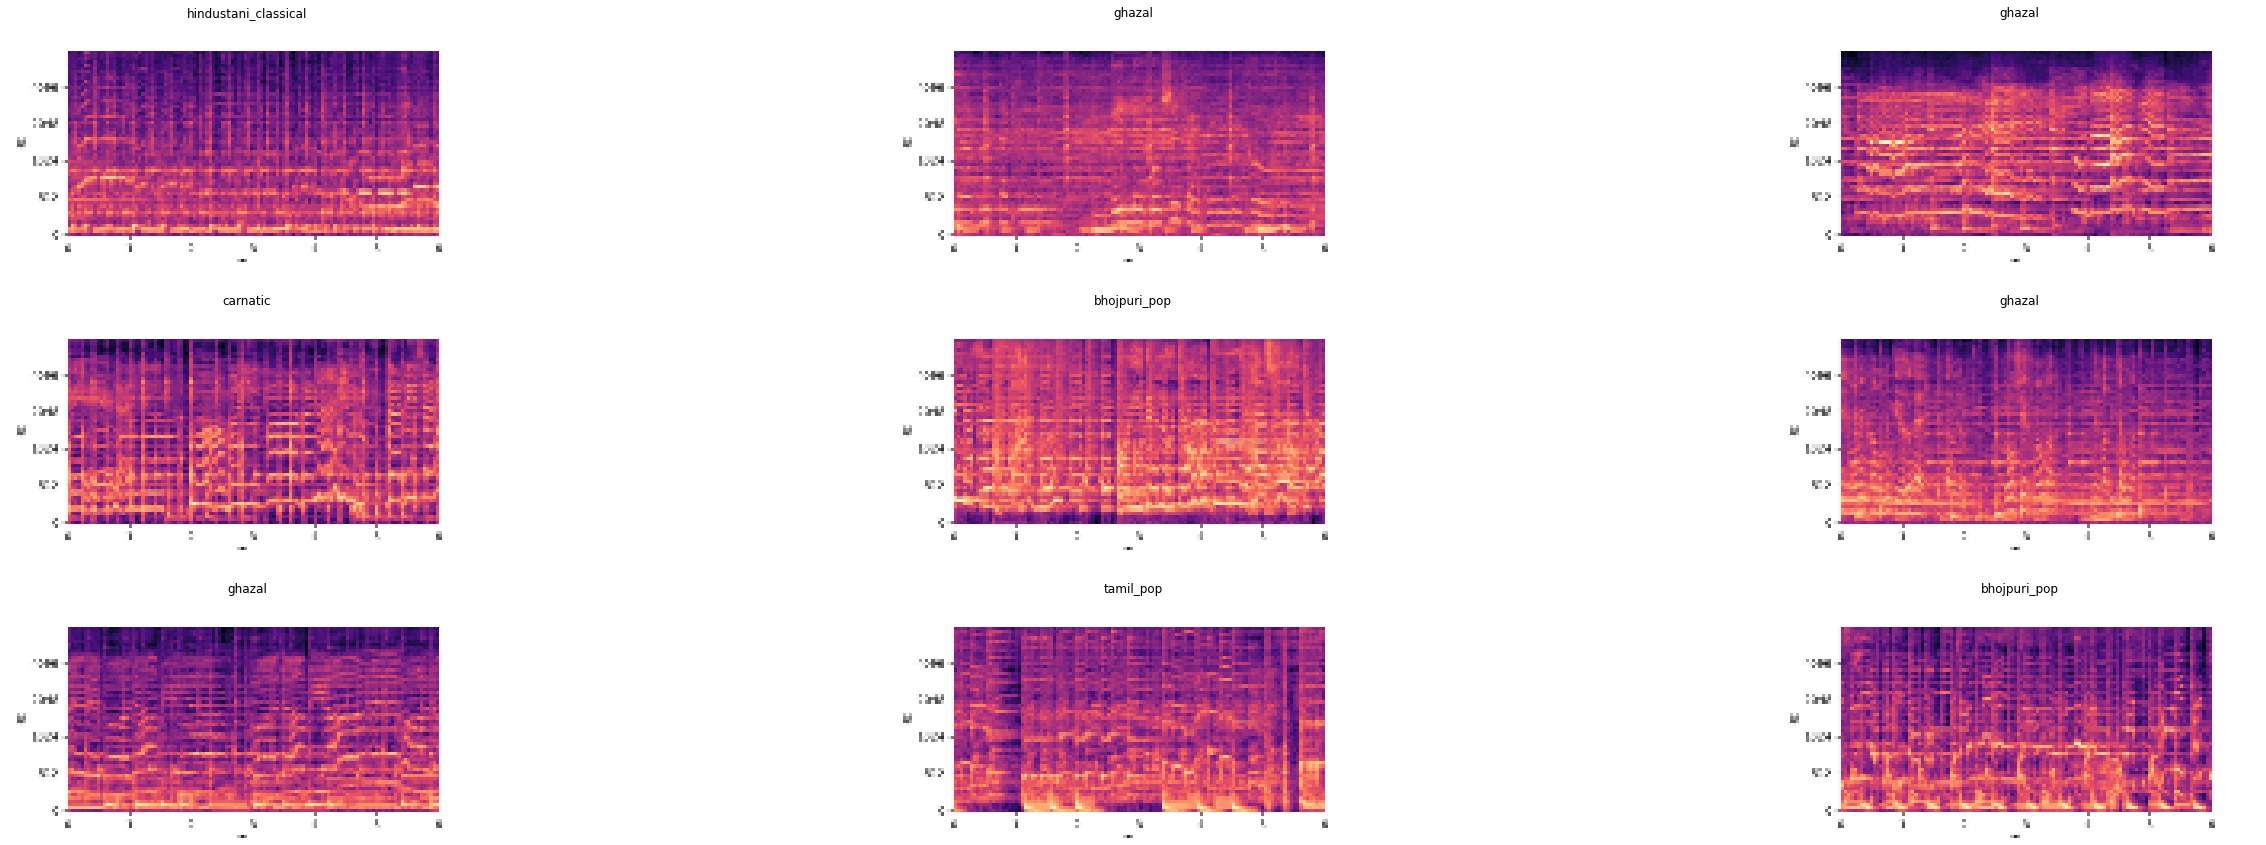

In [10]:
class_names = train_ds.class_names
print(class_names)

import matplotlib.pyplot as plt

plt.figure(figsize=(45, 15))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")


In [11]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(64, 75, 150, 3)
(64,)


In [12]:
normalization_layer = tf.keras.layers.Rescaling(1./255)
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# Notice the pixel values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image))

0.0 1.0


In [13]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [14]:
#model = Sequential(
#    tf.keras.layers.Rescaling(1./255),
#)

In [15]:
num_classes = 10

# 16 - number of filters
# (3,3) - filter size
# 1 - stride of filter
# relu activation - converts negative numbers to 0 (rectified linear activation)
#model.add(Conv2D(16, (3,3), 1, activation='relu', input_shape=(75,150,3)))
#BatchNormalization()
# condenses data 
#model.add(MaxPooling2D())

#model.add(Conv2D(32, (3,3), 1, activation='relu' ))
#BatchNormalization()
#model.add(MaxPooling2D())

#model.add(Conv2D(16, (3,3), 1, activation='relu' ))
#BatchNormalization()
#model.add(MaxPooling2D())

# condensing into single output
#model.add(Flatten())

#model.add(Dense(256, activation='relu'))
#BatchNormalization()
#model.add(Dropout(rate=0.2))
# softmax activation - maps to a multiclass classification
#model.add(Dense(num_classes, activation='softmax'))
model = tf.keras.Sequential([
  tf.keras.layers.Rescaling(1./255),
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.BatchNormalization(),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.BatchNormalization(),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.BatchNormalization(),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.BatchNormalization(),
  # tf.keras.layers.Dropout(rate=0.2),
  tf.keras.layers.Dense(num_classes)
])

In [16]:
model.compile('adam',loss=tf.losses.SparseCategoricalCrossentropy(),metrics=['accuracy'])
#model.summary()

In [17]:
logdir='logs'
tensorboard_callback=tf.keras.callbacks.TensorBoard(log_dir=logdir)
early = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', min_delta=0, patience=20, verbose=1, mode='auto')
hist=model.fit(train_ds,epochs=10,validation_data=val_ds,callbacks=[tensorboard_callback,early])

Epoch 1/10
375/375 [==============================] - 177s 468ms/step - loss: 4.4528 - accuracy: 0.1663 - val_loss: 3.6135 - val_accuracy: 0.1180
Epoch 2/10
375/375 [==============================] - 135s 359ms/step - loss: 3.5718 - accuracy: 0.1430 - val_loss: 9.6640 - val_accuracy: 0.1035
Epoch 3/10
375/375 [==============================] - 131s 348ms/step - loss: 3.3247 - accuracy: 0.1411 - val_loss: 6.1136 - val_accuracy: 0.1393
Epoch 4/10
375/375 [==============================] - 130s 348ms/step - loss: 3.2236 - accuracy: 0.1363 - val_loss: 4.5760 - val_accuracy: 0.1158
Epoch 5/10
375/375 [==============================] - 127s 340ms/step - loss: 2.8927 - accuracy: 0.1468 - val_loss: 2.8570 - val_accuracy: 0.1292
Epoch 6/10
375/375 [==============================] - 130s 348ms/step - loss: 3.0408 - accuracy: 0.1641 - val_loss: 3.3716 - val_accuracy: 0.1058
Epoch 7/10
375/375 [==============================] - 134s 356ms/step - loss: 2.9807 - accuracy: 0.1355 - val_loss: 8.1363 -

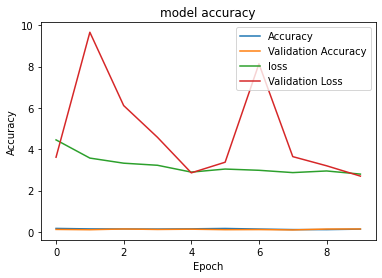

In [18]:
plt.plot(hist.history["accuracy"])
plt.plot(hist.history['val_accuracy'])
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title("model accuracy")
plt.ylabel("Accuracy")
plt.xlabel("Epoch")
plt.legend(["Accuracy","Validation Accuracy","loss","Validation Loss"])
plt.show()


In [19]:
num_classes = 10
model = tf.keras.models.Sequential()

model.add(tf.keras.layers.Rescaling(1./255))
model.add(tf.keras.layers.Input(shape=(75, 150, 3)))
model.add(tf.keras.layers.Conv2D(16, 3, strides=2, padding='same', activation='relu'))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.Conv2D(16, 3, padding='same', activation='relu'))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.Conv2D(16, 3, padding='same', activation='relu'))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(256, activation='relu'))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.Dropout(0.5))
model.add(tf.keras.layers.Dense(num_classes, activation='softmax'))

# Compile model
model.compile('adam',loss=tf.losses.SparseCategoricalCrossentropy(),metrics=['accuracy'])

In [20]:
num_classes = 10
model = tf.keras.models.Sequential()

model.add(tf.keras.layers.Rescaling(1./255))
model.add(tf.keras.layers.Input(shape=(75, 150, 3)))
model.add(tf.keras.layers.Conv2D(16, 3, strides=2, padding='same', activation='relu'))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.Conv2D(16, 3, padding='same', activation='relu'))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.Conv2D(16, 3, padding='same', activation='relu'))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(256, activation='relu'))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.Dropout(0.5))
model.add(tf.keras.layers.Dense(num_classes, activation='softmax'))

# Compile model
model.compile('adam',loss=tf.losses.SparseCategoricalCrossentropy(),metrics=['accuracy'])

In [21]:
logdir='logs'
tensorboard_callback=tf.keras.callbacks.TensorBoard(log_dir=logdir)
early = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', min_delta=0, patience=20, verbose=1, mode='auto')

In [22]:
hist=model.fit(train_ds,epochs=10,validation_data=val_ds,callbacks=[tensorboard_callback,early])

Epoch 1/10
375/375 [==============================] - 26s 69ms/step - loss: 1.8844 - accuracy: 0.3877 - val_loss: 3.5512 - val_accuracy: 0.1162
Epoch 2/10
375/375 [==============================] - 25s 68ms/step - loss: 1.3961 - accuracy: 0.5145 - val_loss: 1.6817 - val_accuracy: 0.4180
Epoch 3/10
375/375 [==============================] - 25s 67ms/step - loss: 1.2694 - accuracy: 0.5567 - val_loss: 1.4972 - val_accuracy: 0.4865
Epoch 4/10
375/375 [==============================] - 25s 67ms/step - loss: 1.2039 - accuracy: 0.5790 - val_loss: 1.6995 - val_accuracy: 0.4372
Epoch 5/10
375/375 [==============================] - 25s 67ms/step - loss: 1.1336 - accuracy: 0.6045 - val_loss: 1.7817 - val_accuracy: 0.4400
Epoch 6/10
375/375 [==============================] - 25s 67ms/step - loss: 1.0972 - accuracy: 0.6165 - val_loss: 1.6635 - val_accuracy: 0.4617
Epoch 7/10
375/375 [==============================] - 25s 68ms/step - loss: 1.0618 - accuracy: 0.6280 - val_loss: 1.4810 - val_accuracy:

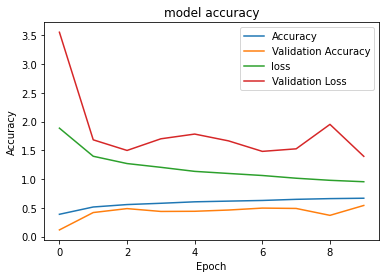

In [23]:
plt.plot(hist.history["accuracy"])
plt.plot(hist.history['val_accuracy'])
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title("model accuracy")
plt.ylabel("Accuracy")
plt.xlabel("Epoch")
plt.legend(["Accuracy","Validation Accuracy","loss","Validation Loss"])
plt.show()


hyperparameter tuning 

In [24]:
num_classes = 10
model = tf.keras.models.Sequential()

model.add(tf.keras.layers.Rescaling(1./255))
model.add(tf.keras.layers.Input(shape=(75, 150, 3)))
model.add(tf.keras.layers.Conv2D(16, 3, strides=2, padding='same', activation='relu'))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.Conv2D(32, 3, padding='same', activation='relu'))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.Conv2D(16, 3, padding='same', activation='relu'))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(256, activation='relu'))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.Dropout(0.5))
model.add(tf.keras.layers.Dense(num_classes, activation='softmax'))

# Compile model
model.compile('adam',loss=tf.losses.SparseCategoricalCrossentropy(),metrics=['accuracy'])

In [25]:
logdir='logs'
tensorboard_callback=tf.keras.callbacks.TensorBoard(log_dir=logdir)
early = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', min_delta=0, patience=20, verbose=1, mode='auto')
hist=model.fit(train_ds,epochs=10,validation_data=val_ds,callbacks=[tensorboard_callback,early])


Epoch 1/10
375/375 [==============================] - 29s 77ms/step - loss: 1.8798 - accuracy: 0.3948 - val_loss: 3.9364 - val_accuracy: 0.1132
Epoch 2/10
375/375 [==============================] - 30s 79ms/step - loss: 1.3652 - accuracy: 0.5248 - val_loss: 1.6364 - val_accuracy: 0.4460
Epoch 3/10
375/375 [==============================] - 29s 78ms/step - loss: 1.2341 - accuracy: 0.5687 - val_loss: 1.5557 - val_accuracy: 0.4792
Epoch 4/10
375/375 [==============================] - 29s 77ms/step - loss: 1.1541 - accuracy: 0.6019 - val_loss: 1.6909 - val_accuracy: 0.4507
Epoch 5/10
375/375 [==============================] - 32s 85ms/step - loss: 1.0992 - accuracy: 0.6188 - val_loss: 2.1518 - val_accuracy: 0.3798
Epoch 6/10
375/375 [==============================] - 36s 96ms/step - loss: 1.0431 - accuracy: 0.6372 - val_loss: 2.0758 - val_accuracy: 0.3705
Epoch 7/10
375/375 [==============================] - 36s 96ms/step - loss: 1.0061 - accuracy: 0.6498 - val_loss: 2.7035 - val_accuracy:

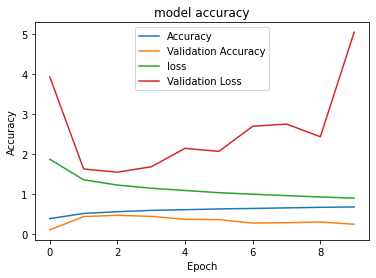

In [26]:
plt.plot(hist.history["accuracy"])
plt.plot(hist.history['val_accuracy'])
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title("model accuracy")
plt.ylabel("Accuracy")
plt.xlabel("Epoch")
plt.legend(["Accuracy","Validation Accuracy","loss","Validation Loss"])
plt.show()
